# Регрессионный анализатор для оценки доменов 

In [1]:
!nvidia-smi

Wed Mar 27 08:16:55 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.65                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 Ti     On  |   00000000:01:00.0  On |                  N/A |
| 53%   32C    P5             20W /  310W |    2584MiB /   8192MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install pycaret
!pip install mlflow
%pip install scipy==1.11.4

from pycaret.classification import *

from pycaret.regression import RegressionExperiment

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [25]:
dataset_file_name = 'work/datasets/processed_actual/merged_full_2024_03_27.csv'

In [12]:
df = pd.read_csv(dataset_file_name)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239257 entries, 0 to 239256
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   domain            239257 non-null  object 
 1   tld               239257 non-null  object 
 2   levels_count      239257 non-null  int64  
 3   levels_mad        239257 non-null  float64
 4   symbols_count     239257 non-null  int64  
 5   vowels_ratio      239257 non-null  float64
 6   consonants_ratio  239257 non-null  float64
 7   numbers_ratio     239257 non-null  float64
 8   points_ratio      239257 non-null  float64
 9   special_ratio     239257 non-null  float64
 10  unique_ratio      239257 non-null  float64
 11  max_repeated      239257 non-null  int64  
 12  a_records         239257 non-null  int64  
 13  mx_records        239257 non-null  int64  
 14  cname_records     239257 non-null  int64  
 15  txt_records       239257 non-null  int64  
 16  ptr_records       23

## Визуализация и анализ собранных данных

In [14]:
plt.style.use('fivethirtyeight')

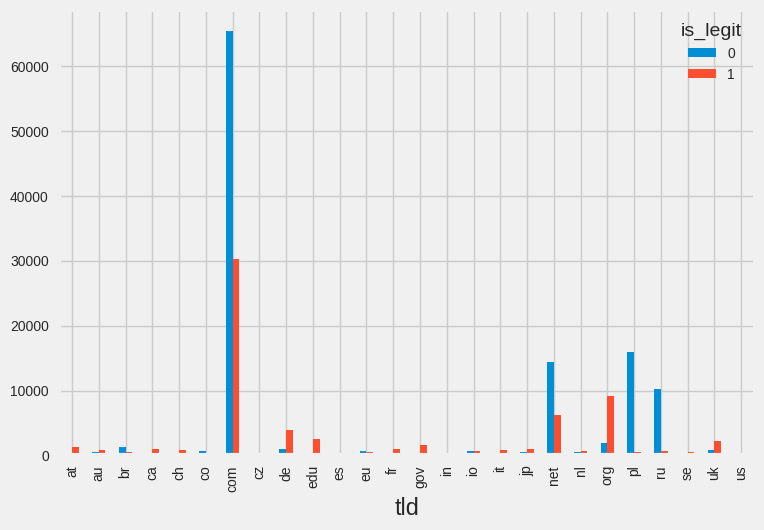

In [27]:
count_by_tld = df.groupby(['tld', 'is_legit']).size().unstack(level=1)
count_by_tld = count_by_tld[count_by_tld[1] > 250]

count_by_tld.plot(kind='bar')
plt.savefig('savefig_tld.png')

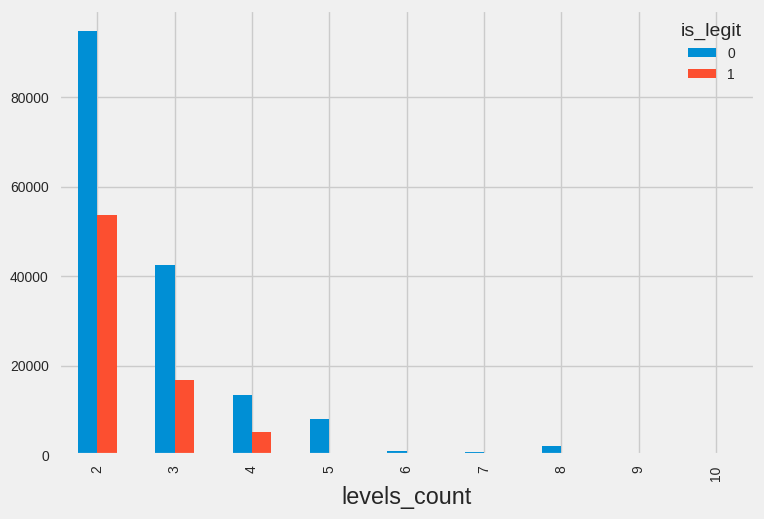

In [28]:
count_by_levels = df.groupby(['levels_count', 'is_legit']).size().unstack(level=1)
count_by_levels = count_by_levels[count_by_levels[0] > 5]

count_by_levels.plot(kind='bar')
plt.savefig('savefig_levels.png')

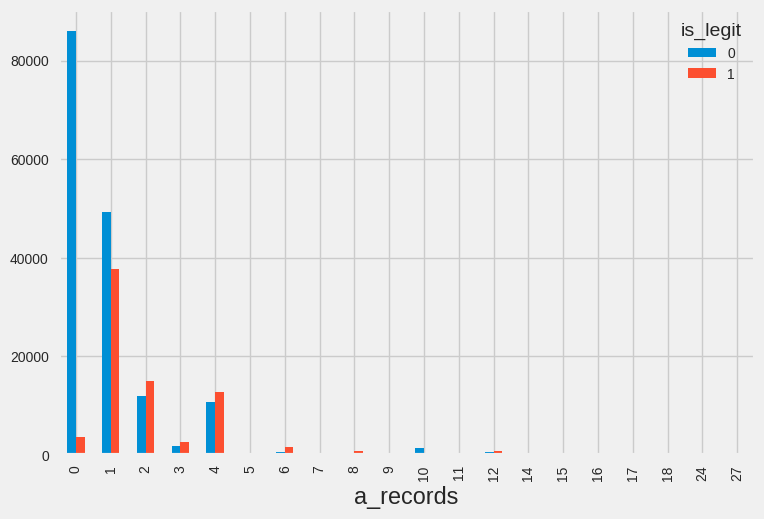

In [29]:
count_by_a_records = df.groupby(['a_records', 'is_legit']).size().unstack(level=1)
count_by_a_records = count_by_a_records[count_by_a_records[1] > 1]

count_by_a_records.plot(kind='bar')
plt.savefig('savefig_a_records.png')

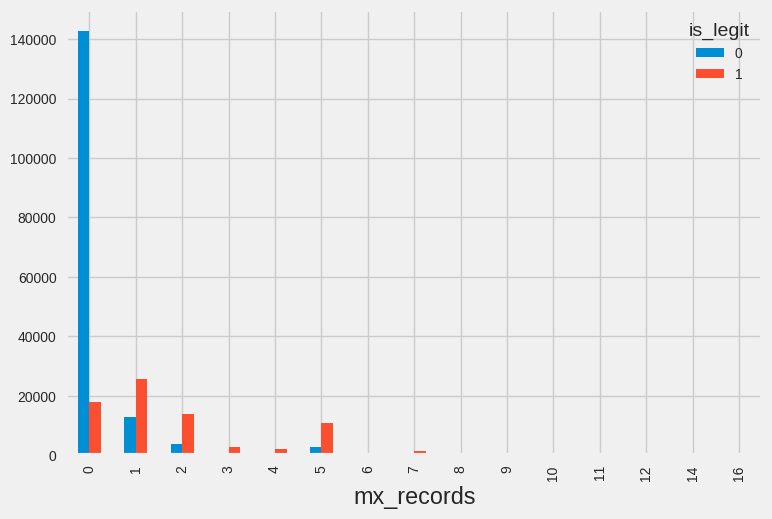

In [30]:
count_by_mx_records = df.groupby(['mx_records', 'is_legit']).size().unstack(level=1)
count_by_mx_records = count_by_mx_records[count_by_mx_records[1] > 1]

count_by_mx_records.plot(kind='bar')
plt.savefig('savefig_mx_records.png')

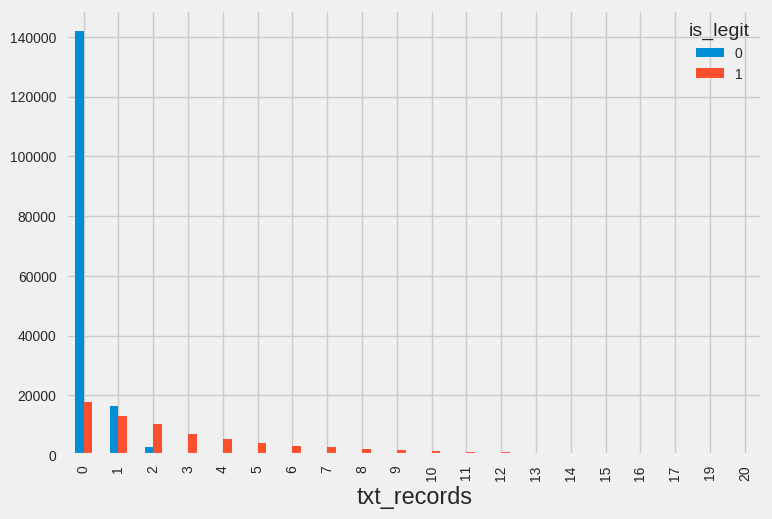

In [31]:
count_by_txt_records = df.groupby(['txt_records', 'is_legit']).size().unstack(level=1)
count_by_txt_records = count_by_txt_records[count_by_txt_records[0] > 5]

count_by_txt_records.plot(kind='bar')
plt.savefig('savefig_txt_records.png')

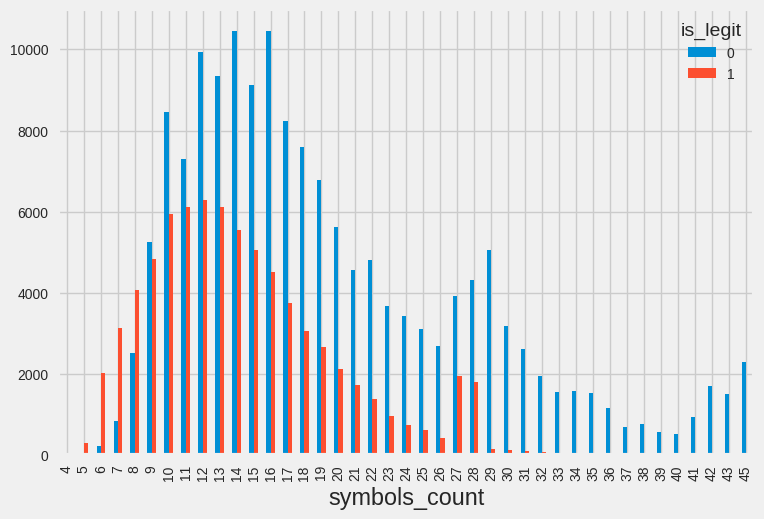

In [32]:
count_by_length_records = df.groupby(['symbols_count', 'is_legit']).size().unstack(level=1)
count_by_length_records = count_by_length_records[count_by_length_records[1] > 1]

count_by_length_records.plot(kind='bar')
plt.savefig('savefig_length_records.png')

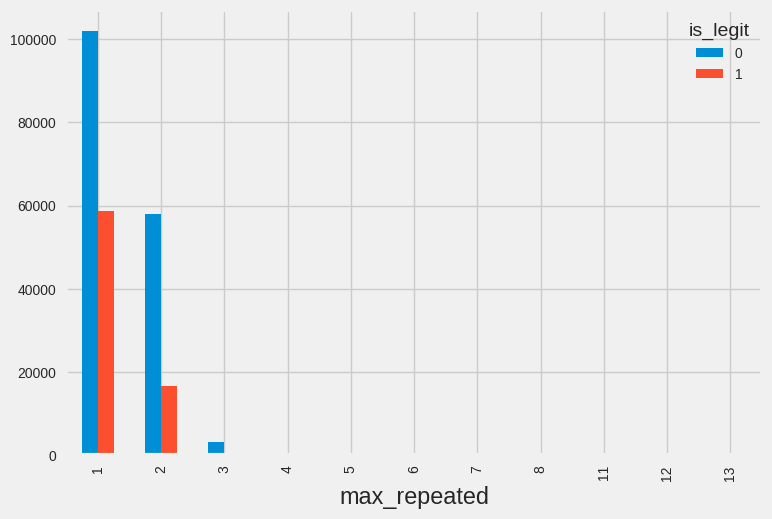

In [33]:
count_by_repeated_records = df.groupby(['max_repeated', 'is_legit']).size().unstack(level=1)
# count_by_repeated_records = count_by_repeated_records[count_by_repeated_records[1] > 1]

count_by_repeated_records.plot(kind='bar')
plt.savefig('savefig_repeated_records.png')

## Семантический анализ

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183479 entries, 0 to 183478
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   domain            183479 non-null  object 
 1   tld               183479 non-null  object 
 2   levels_count      183479 non-null  int64  
 3   levels_mad        183479 non-null  float64
 4   symbols_count     183479 non-null  int64  
 5   vowels_ratio      183479 non-null  float64
 6   consonants_ratio  183479 non-null  float64
 7   numbers_ratio     183479 non-null  float64
 8   points_ratio      183479 non-null  float64
 9   special_ratio     183479 non-null  float64
 10  unique_ratio      183479 non-null  float64
 11  max_repeated      183479 non-null  int64  
 12  a_records         183479 non-null  int64  
 13  mx_records        183479 non-null  int64  
 14  cname_records     183479 non-null  int64  
 15  txt_records       183479 non-null  int64  
 16  ptr_records       18

In [26]:
df = pd.read_csv(dataset_file_name)

df_semantic = df[
    ["domain", "levels_count", "levels_mad", "symbols_count", "vowels_ratio", "consonants_ratio", "numbers_ratio",
     "points_ratio", "special_ratio", "unique_ratio", "max_repeated", "is_legit"]]

df_semantic = df_semantic.astype({'domain': 'string'})

In [8]:
s = ClassificationExperiment()
s.setup(df_semantic, target='is_legit', session_id=123, use_gpu=True, log_experiment=False, experiment_name='semantic_classification')

best_classification_model = s.compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,123
1,Target,is_legit
2,Target type,Binary
3,Original data shape,"(183479, 12)"
4,Transformed data shape,"(183479, 12)"
5,Transformed train set shape,"(128435, 12)"
6,Transformed test set shape,"(55044, 12)"
7,Numeric features,10
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
2024/03/24 19:39:54 INFO mlflow.tracking.fluent: Experiment with name 'semantic_classification' does not exist. Creating a new experiment.


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8933,0.5318,0.0311,0.7499,0.0596,0.0514,0.1383,0.8390
dummy,Dummy Classifier,0.8910,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.3090
nb,Naive Bayes,0.8909,0.5000,0.0000,0.0000,0.0000,-0.0002,-0.0032,0.3100
dt,Decision Tree Classifier,0.8909,0.5000,0.0000,0.0000,0.0000,-0.0002,-0.0027,0.3510
svm,SVM - Linear Kernel,0.8909,0.0000,0.0002,0.1167,0.0004,0.0002,0.0016,0.3810
lr,Logistic Regression,0.8909,0.8519,0.0000,0.0000,0.0000,-0.0002,-0.0032,0.6360
ridge,Ridge Classifier,0.8909,0.0000,0.0000,0.0000,0.0000,-0.0002,-0.0032,0.3190
rf,Random Forest Classifier,0.8909,0.5186,0.0000,0.0000,0.0000,-0.0002,-0.0032,0.9500
ada,Ada Boost Classifier,0.8909,0.5328,0.0000,0.0000,0.0000,-0.0002,-0.0032,2.4570
qda,Quadratic Discriminant Analysis,0.8909,0.5000,0.0000,0.0000,0.0000,-0.0002,-0.0032,0.3600


In [11]:
r = RegressionExperiment()
r.setup(df_semantic, target='is_legit', session_id=123, use_gpu=True, log_experiment=False, experiment_name='semantic_classification')

best_regression_model = r.compare_models()

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,123
1,Target,is_legit
2,Target type,Regression
3,Original data shape,"(183479, 12)"
4,Transformed data shape,"(183479, 12)"
5,Transformed train set shape,"(128435, 12)"
6,Transformed test set shape,"(55044, 12)"
7,Numeric features,10
8,Categorical features,1
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
omp,Orthogonal Matching Pursuit,0.1943,0.0896,0.2994,0.0708,0.2103,0.8285,0.3040
en,Elastic Net,0.1883,0.0923,0.3037,0.0437,0.2114,0.8677,0.2960
et,Extra Trees Regressor,0.1881,0.0954,0.3088,0.0117,0.2151,0.8892,0.6520
ridge,Ridge Regression,0.1914,0.0962,0.3102,0.0026,0.2166,0.8907,0.3130
br,Bayesian Ridge,0.1916,0.0964,0.3105,0.0009,0.2169,0.8915,0.3630
lr,Linear Regression,0.1916,0.0964,0.3105,0.0009,0.2169,0.8915,0.3170
lasso,Lasso Regression,0.1930,0.0965,0.3106,-0.0001,0.2171,0.8918,0.3420
llar,Lasso Least Angle Regression,0.1930,0.0965,0.3106,-0.0001,0.2171,0.8918,0.3550
dummy,Dummy Regressor,0.1930,0.0965,0.3106,-0.0001,0.2171,0.8918,0.2780
par,Passive Aggressive Regressor,0.2321,0.0971,0.3115,-0.0062,0.2251,0.8242,0.3460
